Tim, sorry to bother you, but could you take a look at this specific case? There’s a situation where z is 0.4124758375101626 and i is 0.12368466199063323, and in this setup, rho_m matches rho_hat. 

However, in such cases, R fits in this way. I think it might require some adjustments within the module.

In [1]:
import bcw_bj
import numpy as np
import scipy as sp
from textwrap import dedent
from scipy.optimize import brentq, fsolve
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import sys
import time
import collections as collections
from cycler import cycler

from scipy.spatial import ConvexHull
import setops as setops # Custom module by TK, from CSM

import sympy as sym
from IPython.display import display, Math

In [2]:
# Instantiate class as MODEL object, at current calibrated params
self = bcw_bj.baseline_mod(σ_DM=0.28, c=1.0,n=0.8)

# Set (partial) equilibrium i to calibrated SME solution
i = 0.12368466199063323

## New functions added

In [3]:
def z_cutoffs(self, i):
    """Define the four cutoff levels for z as in Lemmata 1-3:
    0 < z_tilde_i < zhat < z_prime < ∞."""

    z_hat = (self.c/(1-self.σ_DM))**((self.σ_DM-1)/self.σ_DM)
    z_prime = z_hat*(1/(1-self.σ_DM))**(-(self.σ_DM-1)/self.σ_DM)
    z_tilde = z_hat*(1+i)**(-1/self.σ_DM)
    # z_breve = (1-self.c) + z_hat*self.σ_DM
    # z_breve =((1+self.σ_DM*z_tilde)/self.c)**(1-self.σ_DM)
    
    # Sanity check!
    # zcut = np.diff([z_tilde, z_hat])
    if z_tilde <= z_hat:
        print("🥳 Congrats: Your cutoffs are in order!")
        z_cutoffs_str = '\\tilde{z}_{i} < \\hat{z} < z^{\\prime}'
        display(
            Math(z_cutoffs_str)
            )
        z_cutoffs = [z_tilde, z_hat, z_prime] 
        print(['%.3f' % x for x in z_cutoffs])
    else:
        print("💩 You have a problem with your cutoff ordering!")
            
    return z_tilde, z_hat, z_prime 

In [4]:
def R(self, p_grid, Rex, DropFakes=True):
    """Find convex hull of graph(Rex) to get R - See Appendix B.3
    Taken from https://github.com/phantomachine/csm/
    """
    Rex_graph = np.column_stack((p_grid, Rex))
    
    # Step 0:   Find Convex hull of { ρ, Rex(ρ) }
    mpoint = np.array([p_grid.max(), Rex.min()])  # SE corner
    graph = np.vstack((Rex_graph, mpoint))
    chull = ConvexHull(graph)
    extreme_pts = graph[chull.vertices, :]
    
    # Step 1: Intersection between original function Rex and ext. pts.
    v_intersect_graph, ind = setops.intersect(Rex_graph, extreme_pts)[0:2]
    
    # Step 2: First difference the index locations
    idiff = np.diff(ind, n=1, axis=0)

    print(self.ρ_hat_func(z))
    print(v_intersect_graph[-1][0])

    print(self.ρ_hat_func(z)- v_intersect_graph[-1][0])
    
    # Step 3: if idiff contains elements > 1 then we know exist one/more line 
    # segment (i.e., more than one set of lotteries played). Location where 
    # straddles more than 1 step
    idz = np.where(idiff > 1)[0]
   
    # Step 4: Given the jumps, we have the end points defining each lottery!
    idz = np.column_stack((idz, idz+1))

    # Step 5: Store lottery supports
    lottery_supports = v_intersect_graph[idz, 0]
    lottery_payoffs = v_intersect_graph[idz, 1]

    # print(lottery_supports)
    # Step 6: Interpolate to approximate R
    R_fit = self.InterpFun1d(v_intersect_graph[:, 0],
                            v_intersect_graph[:, 1])

    print(v_intersect_graph[:, 0])
    # Step 7: Eliminate Fake Lotteries (below-tolerance numerical imprecisions)
    if DropFakes:
        selector = []
        for idx_lot in range(lottery_supports.shape[0]):
            # Lottery prizes for at current lottery segment, idx_lot
            p_lo, p_hi = lottery_supports[idx_lot, :]
            # Conditions: points between current lottery segment
            find_condition = (p_grid > p_lo) & (p_grid < p_hi)
            # Value of Vtilde between current lottery segment
            Rex_p_temp = Rex[find_condition]
            # Value of V between current lottery segment
            R_p_temp = R_fit(p_grid[find_condition])
            # Check: Is R "significantly different" from Rex at lottery segment?
            gap = np.absolute(R_p_temp - Rex_p_temp).max()
            if gap > 1e-10:
                selector.append(idx_lot)  # Keep, if "YES"
        # Update definition of the set of lotteries
        lottery_supports_temp = lottery_supports[selector, :]
        lottery_payoffs_temp = lottery_payoffs[selector, :]
        # if lottery_supports_temp.size == 0:
        #     lottery_supports = lottery_supports[0, :]
        #     lottery_payoffs = lottery_payoffs[0, :]
        # else:
        if lottery_supports_temp.size > 0:
            lottery_supports = lottery_supports_temp
            lottery_payoffs = lottery_payoffs_temp
    # print(lottery_supports)
    # Step 8: Store R as evaluated on finite set p_grid
    R_grid = R_fit(p_grid)
    return R_grid, R_fit, lottery_supports, lottery_payoffs

In [5]:
def plotRfun(self, i, z, ρ_range):

        ρ_hat = self.ρ_hat_func(z)
        ρ_tilde = self.ρ_tilde_func(z, i)
        ρ_m0 = self.c/(1-self.σ_DM)
        # ρ_range = np.linspace(self.c, 1.5, 1000)

        fig, ax = plt.subplots()
        # Graph - profit from credit buyers
        plt.plot(ρ_range, self.G1(ρ_range, i, z),
                label=r"$G_{1}$", color="b", linestyle='dotted')
        # Graph - profit from money constrained
        plt.plot(ρ_range, self.G2(ρ_range, i, z),
                label=r"$G_{2}$", color="orange", linestyle="--")
        # Graph - profit from money unconstrained
        plt.plot(ρ_range, self.G3(ρ_range, i, z),
                label=r"$G_{3}$", color="green", linestyle='dashdot')
        # Ex-post profit (R^{ex})
        Rex = self.R_ex(ρ_range, i, z)
        plt.plot(ρ_range, Rex,
                label=r"$R^{ex}$",
                color="r",
                linewidth=2.5,
                alpha=0.7,)

        # Effective (ex-ante) but post-match lottery value/profit, R
        R_grid = R(self, ρ_range, Rex, DropFakes=True)[0]
        plt.plot(ρ_range, R_grid, '-k', label=r"$R$", alpha=0.9,)

        # Add tick-marks for pricing cutoffs and Ramsey monopoly price
        ax.set_xticks(ticks=[self.c, ρ_hat, ρ_tilde, ρ_m0],
                                labels=[r"$c$", 
                                        r"$\hat{\rho}$", 
                                        r"$\tilde{\rho}_{i}$", 
                                        r"$\rho^{m}_{0}$"]
                        )

        plt.legend()
        plt.show()
    
        return plt, fig, ax, ρ_hat, ρ_tilde, ρ_m0

1.411130715052099
1.411130715052099
0.0
[1.         1.00013709 1.00027418 ... 1.41085654 1.41099363 1.41113072]


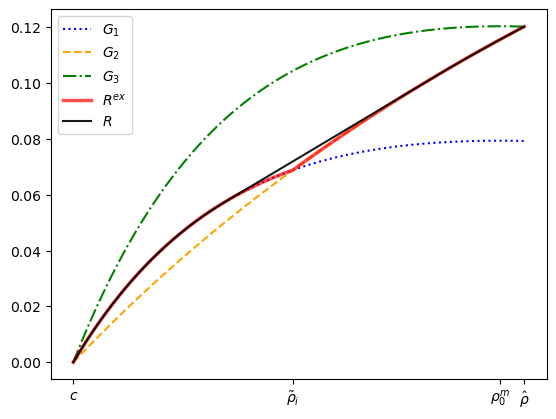

In [8]:
z= 0.4124758375101626
i = 0.12368466199063323
τ = 0.1

ρ_range = np.linspace(self.c, self.ρ_hat_func(z), 3000)
weight = 0.5
#plt.plot(self.R_ex(ρ_range, i, z))
plt, fig, ax, ρ_hat, ρ_tilde, ρ_m0 = plotRfun(self, i, z, ρ_range)